## Import main functions

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/l4_dataset')

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os, copy
%matplotlib inline

imw = 192
imh = 192
c = 3
RS = 2211

In [0]:
import seaborn as sns
import matplotlib.patheffects as PathEffects

In [0]:
from sklearn.manifold import TSNE
import umap
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, LeakyReLU, PReLU
from keras.models import Model
from keras import backend as K
from sklearn.cluster import KMeans

Using TensorFlow backend.


## Helper functions

In [0]:
def low_clip(x):
    x[x<=255] = 0
    return x

def minmax(x):
    return (x-x.min())/(x.max()-x.min())

def max_normalise(x):
    max = np.max(x)
    return x / max
    
def is_faulty(x):
  if x.max() <= 255:
    return True
  return False

In [0]:
def get_label(filename):
    # 0: unstimulated
    # 1: OVA
    # 2: ConA
    # 3: empty

    # filename format: folder/CKX - L - 00(...)
    file = filename.split("/")[-1].split("(")[0]

    # get letter for DMSO indices
    letter = file.split('-')[1].strip()

    # get number
    number = file[-2:].strip()

    # get plate layout number
    ck = file[:4]

    # DMSO = []

    if ck == "CK19":
        #if number in ["5", "8", "11", "15", "18", "21"] and letter in ["N", "O", "P"]:
        #   DMSO.append(len(labels))
        if number in ["3", "4", "5", "6", "7", "8", "24"]:
            label = 0
        elif number in ["9", "10", "11", "13", "14", "15", "23"]:
            label = 1
        elif number in ["16", "17", "18", "19", "20", "21", "22"]:
            label = 2
        else:
            label = 3
    elif ck == "CK21" or ck == "CK22":
        if number in ["02", "03", "04", "05", "06", "07", "08", "09", "10", "11"]:
            label = 0
        elif int(number) in range(14, 24):
            label = 2
        else:
            label = 3
        #if label != 3 and letter in ["H", "P"]:
        #    DMSO.append(len(labels))
    else:
        print("No CK found")
        return False

    return label
  
def unishuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [0]:
def show_image(img, title="untitled", cmap="gray", **kwargs):
    try:
        plt.imshow(img, cmap=cmap, **kwargs)
    except:
        plt.imshow(img[:, :, 0], cmap=cmap, **kwargs)
    plt.axis("off")
    plt.title(title)

In [0]:
def convert_to_binary(a):
    val = np.unique(a)[1]
    mask = np.copy(a)
    for idx, pixel in enumerate(a):
        if pixel == val:
            mask[idx] = 1
        else:
            mask[idx] = 0
    return mask.astype(np.uint8)

def get_mask(img):
    kmeans = KMeans(2).fit(img.reshape(np.prod(img.shape), 1))
    return convert_to_binary(kmeans.cluster_centers_[kmeans.labels_])

In [0]:
def plot_range(imgs, rn=8):
  fig = plt.figure(figsize=(15, 15))
  for i in range(1, 6):
    ax = fig.add_subplot(1, 5, i)
    plt.imshow(imgs[i+rn])
    ax.axis('off')

## Helper functions for evaluating model

In [0]:
def plot_tsne(X, y, labels=["Unstimulated", "OVA", "ConA"]):
    targets = range(len(labels))
    palette = np.array(sns.color_palette("hls", len(labels)))

    y = np.array(y)

    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot()

    for target, color, label in zip(targets, palette, labels):
        plt.scatter(X[y==target, 0], X[y==target, 1], c=[color], label=label, alpha=0.5)

    ax.axis('off')
    ax.grid(False)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [0]:
# credit: https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md

def visualise_activations(model, images):
  idx = np.random.randint(2, len(images))
  l = len(model.layers)-1
  layer_outputs = [layer.output for layer in model.layers[1:l]]
  activation_model = Model(inputs=model.input, outputs=layer_outputs)
  # Choose random image to predict for
  activations = activation_model.predict(images[12:14])

  layer_names = []
  for layer in model.layers[1:l//2]:
      layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

  images_per_row = 8

  for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
      n_features = layer_activation.shape[-1] # Number of features in the feature map
      size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
      n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
      display_grid = np.zeros((size * n_cols, images_per_row * size))
      for col in range(n_cols): # Tiles each filter into a big horizontal grid
          for row in range(images_per_row):
              channel_image = layer_activation[0,
                                              :, :,
                                              col * images_per_row + row]
              channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
              channel_image /= channel_image.std()
              channel_image *= 64
              channel_image += 128
              channel_image = np.clip(channel_image, 0, 255).astype('uint8')
              display_grid[col * size : (col + 1) * size, # Displays the grid
                          row * size : (row + 1) * size] = channel_image
      scale = 1. / size
      plt.figure(figsize=(scale * display_grid.shape[1],
                          scale * display_grid.shape[0]))
      plt.title(layer_name)
      plt.grid(False)
      plt.imshow(display_grid, aspect='auto', cmap='gray')

In [0]:
plt.rcParams.update({'axes.titlesize': 'medium'})

def run_evaluation(model, data, test, batch_size=48, epochs=30, visualise=False):
    # visualise feature maps
    if visualise:
        visualise_activations(model, data)
    
    # get model image predictions before training
    # @QUESTION: is this a good strategy?
    decoded_before = model.predict(data[21:22])
    test_decoded_before = model.predict(test[21:22])

    # fit model; get before/after weights (make sure there is a change)
    untrained_weights = [np.min(model.get_layer(index=1).get_weights()[0]), np.max(model.get_layer(index=1).get_weights()[0])]
    loss = model.fit(data, data, epochs=epochs, batch_size=batch_size)
    trained_weights = [np.min(model.get_layer(index=1).get_weights()[0]), np.max(model.get_layer(index=1).get_weights()[0])]
    
    # plot the loss
    plt.figure()
    plt.plot(loss.history['loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    
    
    # show the difference in reconstruction
    decoded_imgs = model.predict(data[21:22]) # test on images it trained on
    untrained_decoded = model.predict(test[21:22]) # test images

    s=12
    fig = plt.figure(figsize=(s,s))
    fig.add_subplot(1, 3, 1)
    show_image(reshape(data[21], w=imw, h=imh, c=c), "original training image")
    fig.add_subplot(1, 3, 2)
    show_image(reshape(decoded_imgs[0], w=imw, h=imh, c=c), "reconstructed - after")
    fig.add_subplot(1, 3, 3)
    show_image(reshape(decoded_before[0], w=imw, h=imh, c=c), "reconstructed - before")

    fig = plt.figure(figsize=(s,s))
    fig.add_subplot(1, 3, 1)
    show_image(reshape(test[21], w=imw, h=imh, c=c), "original test image")
    fig.add_subplot(1, 3, 2)
    show_image(reshape(untrained_decoded[0], w=imw, h=imh, c=c), "reconstructed test - after")
    fig.add_subplot(1, 3, 3)
    show_image(reshape(test_decoded_before[0], w=imw, h=imh, c=c), "reconstructed test - before")
              
    # see if weights have changed
    print("Weight difference: {}".format(np.array(untrained_weights)-np.array(trained_weights)))

## Read images

In [0]:
npzfile = np.load('/content/gdrive/My Drive/l4_dataset/dmso_unmodified.npz')

In [0]:
y = npzfile['y']

In [0]:
y_dmso = np.array([get_label(i) for i in y])

In [0]:
X = npzfile['x']

## Process images into dataset

In [0]:
def preprocess(data, labels, mask=False):
  data = np.copy(data)

  # initialise arrays for filling in
  x_data = np.ndarray(shape=(len(data)//2, 192, 192, 3))
  y_data = np.ndarray(shape=(len(data)//2))

  # initialise index values
  idx = 0
  i = 0

  # loop through images and process 
  while idx < (len(data)):
    # ignore 100, 300, etc. values as they will already have been processed 
    if (idx % 100 == 0) and (idx % 200 != 0):
      idx += 100
      print(idx)
    else:
        tcell = minmax(data[idx])
        dcell = minmax(data[idx+100])
        if mask:
          x_data[i, ..., 0] = dcell*(get_mask(dcell).reshape(192,192)) # red-coloured
          x_data[i, ..., 1] = tcell*(get_mask(tcell).reshape(192,192)) # green-coloured
        else:
          x_data[i, :, :, 0] = dcell
          x_data[i, :, :, 1] = tcell
        if is_faulty(data[idx]) or is_faulty(data[idx+100]):
          y_data[i] = 3
        else:
          y_data[i] = labels[idx]
        idx+=1
        i+=1
  
  print('Images preprocessed. Size of dataset: {}'.format(len(x_data)))
  return x_data, y_data

In [0]:
x_combined, y_combined = preprocess(X, y_dmso)

In [0]:
x_masked, y_masked = preprocess(X, y_dmso, mask=True)

In [0]:
x_train, y_train = unishuffle(x_masked, y_masked)

In [0]:
# code to remove outlier images if needed
x_nonzero = []
y_nonzero = []
for idx, x in enumerate(x_combined):
  if np.sum(x) != 0:
    x_nonzero.append(x)
    y_nonzero.append(idx)

In [0]:
x_nonzero = np.array(x_nonzero)
y_nonzero = np.array(y_nonzero)

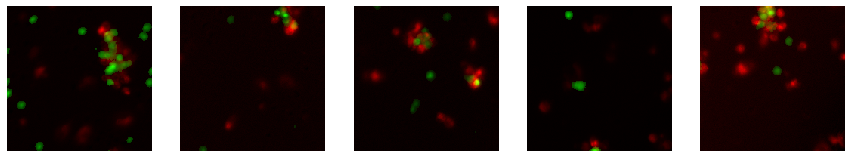

In [0]:
plot_range(x_combined, rn=30)

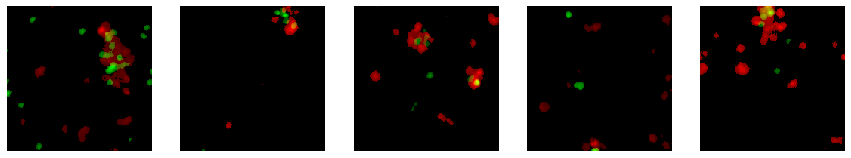

In [0]:
plot_range(x_masked, rn=30)

## Autoencoder model

In [0]:
c = 3

input_img = Input(shape=(imw, imh, c))

x = Conv2D(32, (3, 3), padding='same')(input_img)
x = PReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = PReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = PReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), padding='same', strides=2)(x)
x = PReLU()(x)

encoded = Flatten()(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), padding='same')(x)
x = PReLU()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = PReLU()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding="same")(x)
x = PReLU()(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(c, (3, 3), activation='sigmoid', padding='same')(x)

In [0]:
decoder = Model(input_img, decoded)
decoder.compile(optimizer='adam', loss='binary_crossentropy')

In [0]:
decoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 192, 192, 32)      896       
_________________________________________________________________
p_re_lu (PReLU)              (None, 192, 192, 32)      1179648   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 16)        4624      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 96, 96, 16)        147456    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 16)        0     









Epoch 1/10
9600/9600 [==============================] - 65s 7ms/step - loss: 0.1477
Epoch 2/10
9600/9600 [==============================] - 64s 7ms/step - loss: 0.0981
Epoch 3/10
9600/9600 [==============================] - 64s 7ms/step - loss: 0.0952
Epoch 4/10
9600/9600 [==============================] - 64s 7ms/step - loss: 0.0945
Epoch 5/10
9600/9600 [==============================] - 64s 7ms/step - loss: 0.0940
Epoch 6/10
9600/9600 [==============================] - 64s 7ms/step - loss: 0.0938
Epoch 7/10
9600/9600 [==============================] - 64s 7ms/step - loss: 0.0936
Epoch 8/10
9600/9600 [==============================] - 64s 7ms/step - loss: 0.0935
Epoch 9/10
9600/9600 [==============================] - 64s 7ms/step - loss: 0.0933
Epoch 10/10
9600/9600 [==============================] - 64s 7ms/step - loss: 0.0933
Weight difference: [ 0.36534342 -0.12612827]


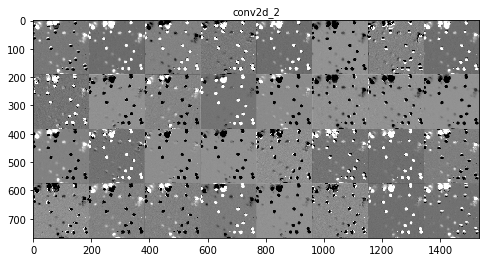

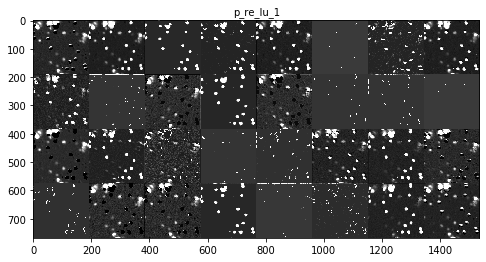

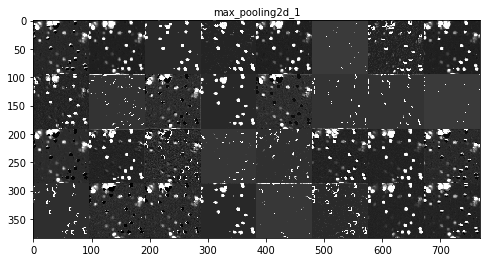

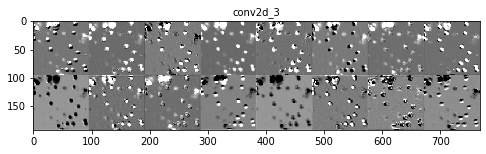

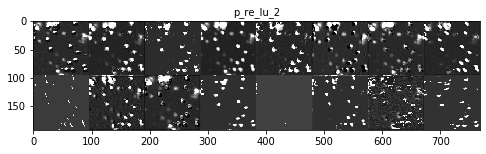

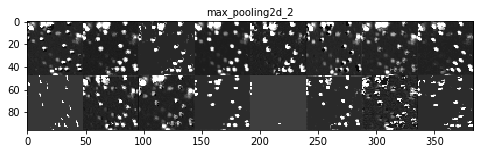

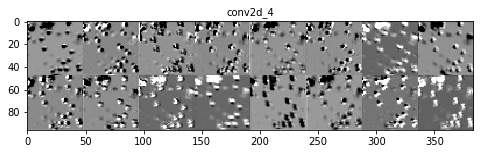

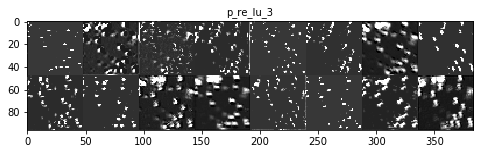

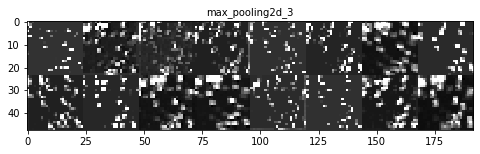

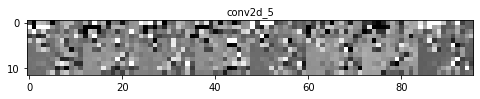

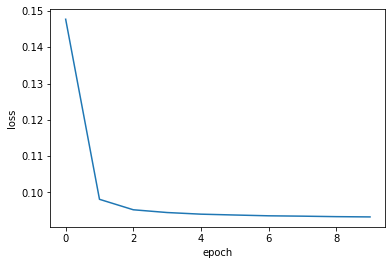

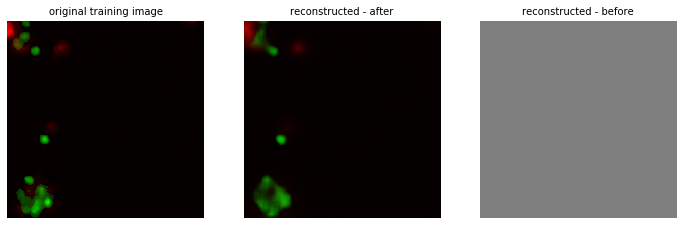

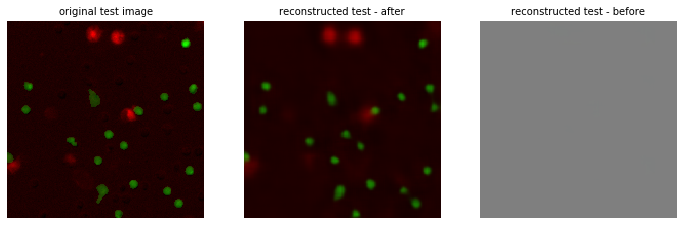

In [0]:
# clipping 255 -> 0
run_evaluation(decoder, x_train[:-200], x_train[-200:], batch_size=32, epochs=10, visualise=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide




Epoch 1/10
9396/9396 [==============================] - 66s 7ms/step - loss: 0.1989
Epoch 2/10
9396/9396 [==============================] - 63s 7ms/step - loss: 0.1647
Epoch 3/10
9396/9396 [==============================] - 63s 7ms/step - loss: 0.1636
Epoch 4/10
9396/9396 [==============================] - 63s 7ms/step - loss: 0.1631
Epoch 5/10
9396/9396 [==============================] - 63s 7ms/step - loss: 0.1628
Epoch 6/10
9396/9396 [==============================] - 63s 7ms/step - loss: 0.1626
Epoch 7/10
9396/9396 [==============================] - 63s 7ms/step - loss: 0.1625
Epoch 8/10
9396/9396 [==============================] - 63s 7ms/step - loss: 0.1624
Epoch 9/10
9396/9396 [==============================] - 63s 7ms/step - loss: 0.1623
Epoch 10/10
9396/9396 [==============================] - 63s 7ms/step - loss: 0.1621
Weight difference: [ 0.39462763 -0.03272921]


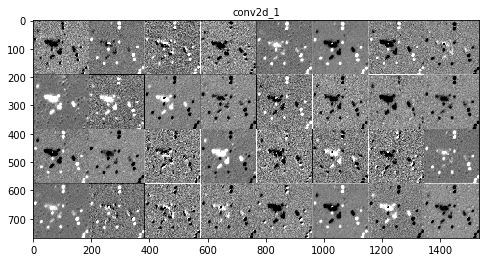

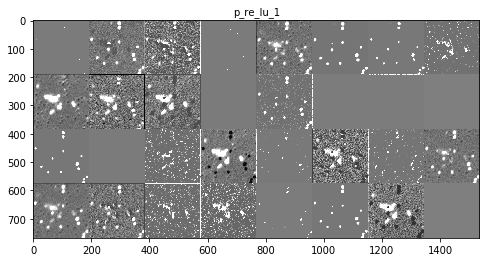

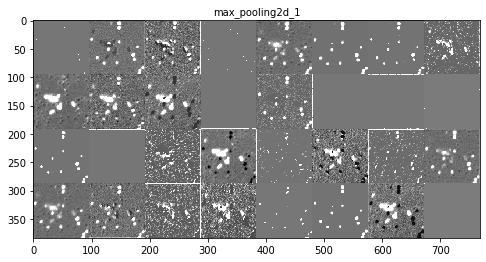

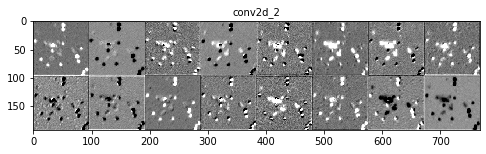

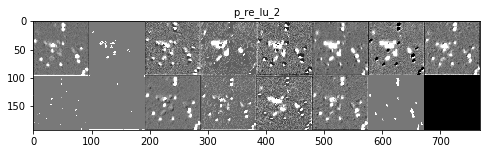

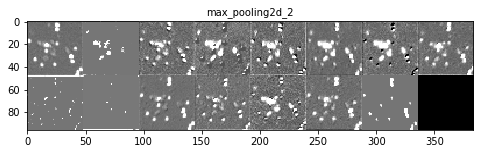

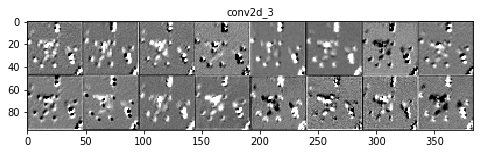

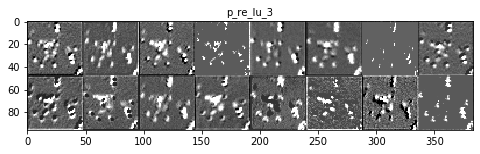

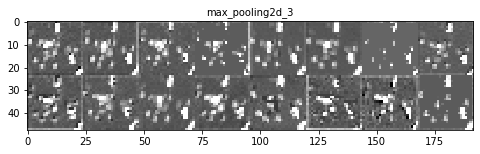

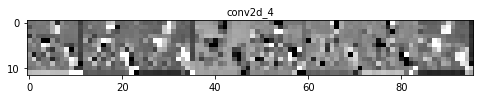

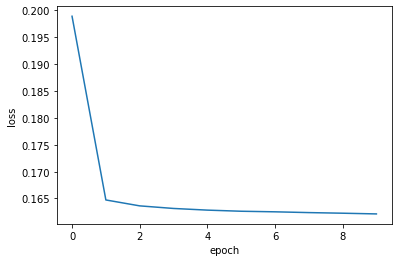

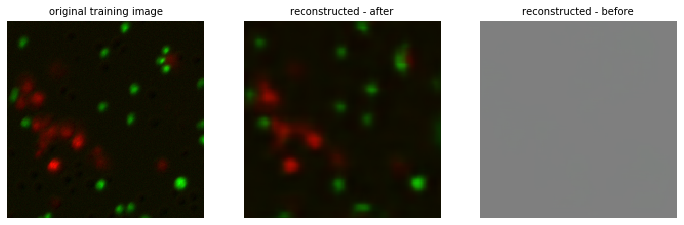

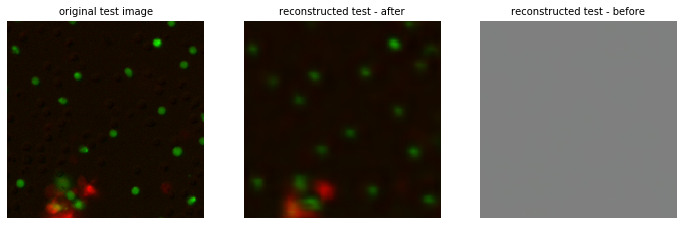

In [0]:
# outlier images completely removed
run_evaluation(decoder, x_nonzero[:-200], x_nonzero[-200:], batch_size=32, epochs=10, visualise=True)









Epoch 1/10
9600/9600 [==============================] - 66s 7ms/step - loss: 0.1288
Epoch 2/10
9600/9600 [==============================] - 64s 7ms/step - loss: 0.0933
Epoch 3/10
9600/9600 [==============================] - 64s 7ms/step - loss: 0.0892
Epoch 4/10
9600/9600 [==============================] - 64s 7ms/step - loss: 0.0882
Epoch 5/10
9600/9600 [==============================] - 64s 7ms/step - loss: 0.0877
Epoch 6/10
9600/9600 [==============================] - 64s 7ms/step - loss: 0.0875
Epoch 7/10
9600/9600 [==============================] - 64s 7ms/step - loss: 0.0873
Epoch 8/10
9600/9600 [==============================] - 64s 7ms/step - loss: 0.0872
Epoch 9/10
9600/9600 [==============================] - 64s 7ms/step - loss: 0.0871
Epoch 10/10
9600/9600 [==============================] - 64s 7ms/step - loss: 0.0870
Weight difference: [ 0.66557044 -0.23898609]


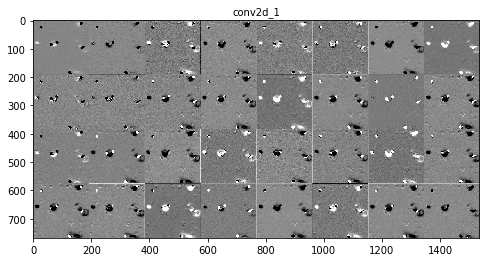

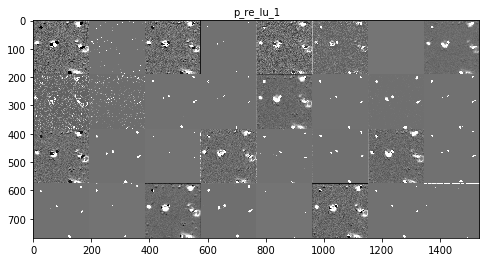

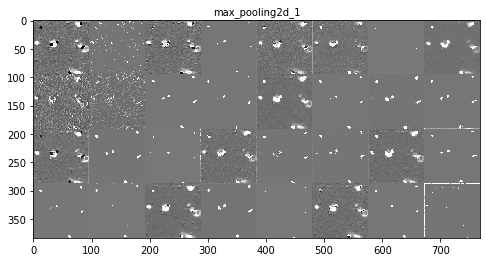

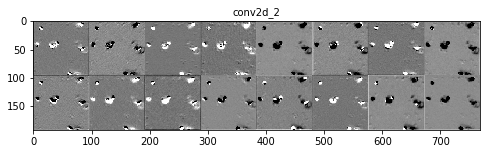

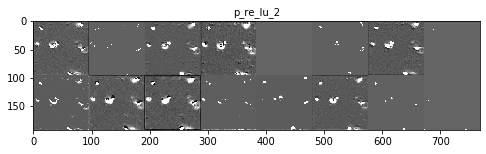

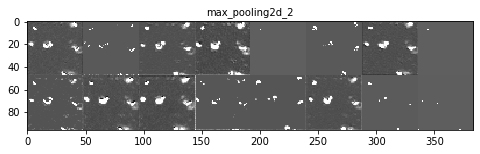

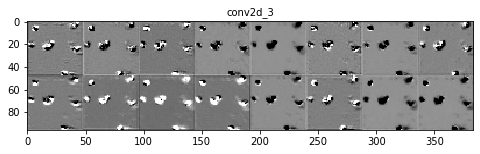

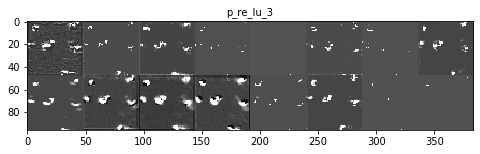

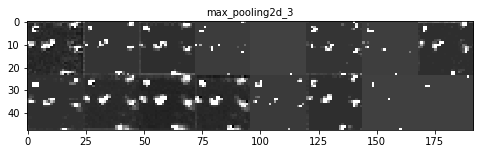

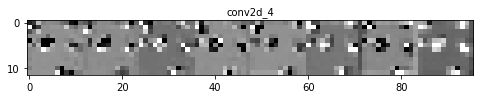

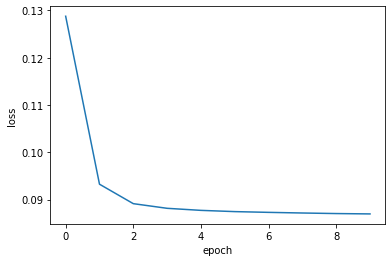

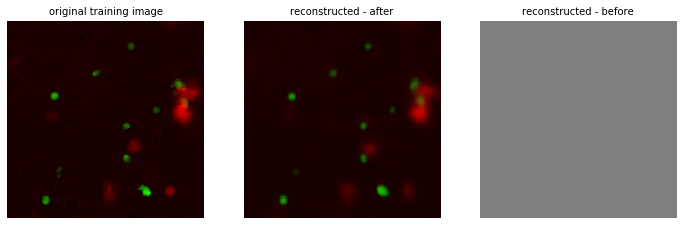

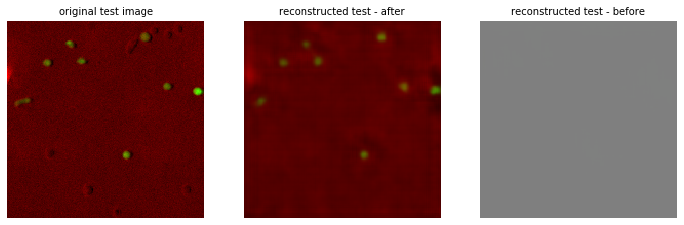

In [0]:
# outlier images blacked out
run_evaluation(decoder, x_train[:-200], x_train[-200:], batch_size=32, epochs=10, visualise=True)

## Clustering results

In [0]:
encoder = Model(input_img, encoded)
encoded = encoder.predict(x_train)

In [0]:
# reduced model with PReLU, non masked out dataset, no low_clip, all images
x_tsne = TSNE(random_state=RS, perplexity=5, learning_rate=200, n_iter=2500).fit_transform(encoded)

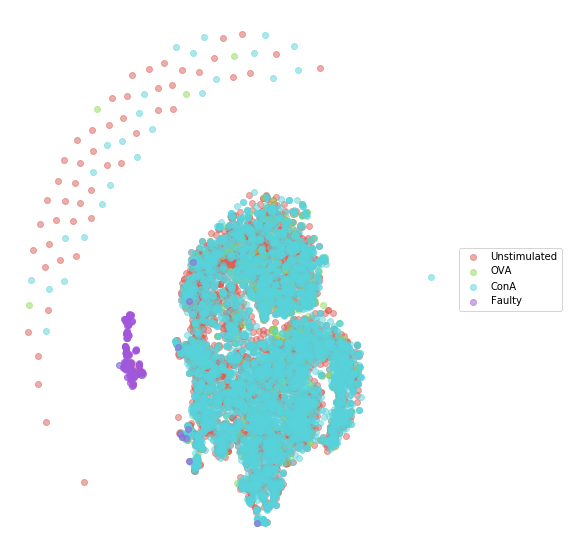

In [0]:
plot_tsne(x_tsne, y_masked, labels=['Unstimulated', 'OVA', 'ConA', 'Faulty'])

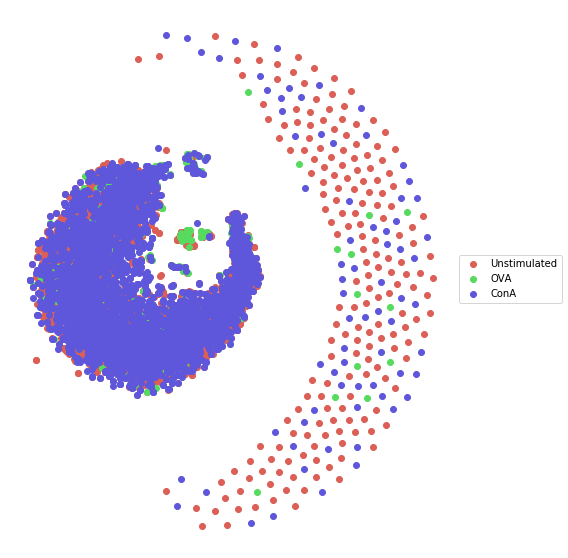

In [0]:
# reduced model with PReLU, non masked out dataset, modified low_clip
x_tsne = TSNE(random_state=RS, perplexity=5, learning_rate=200, n_iter=2500).fit_transform(encoded)
plot_tsne(x_tsne, y_train)

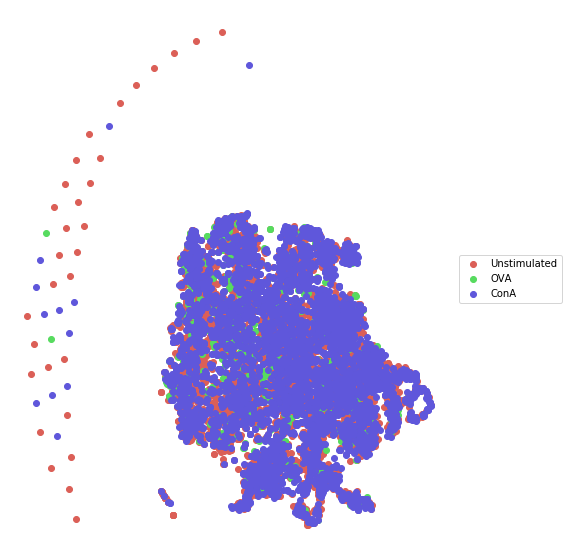

In [0]:
# reduced model with PReLU, non masked out dataset, outliers removed
x_tsne = TSNE(random_state=RS, perplexity=5, learning_rate=200, n_iter=2500).fit_transform(encoded)
plot_tsne(x_tsne, y_nz)

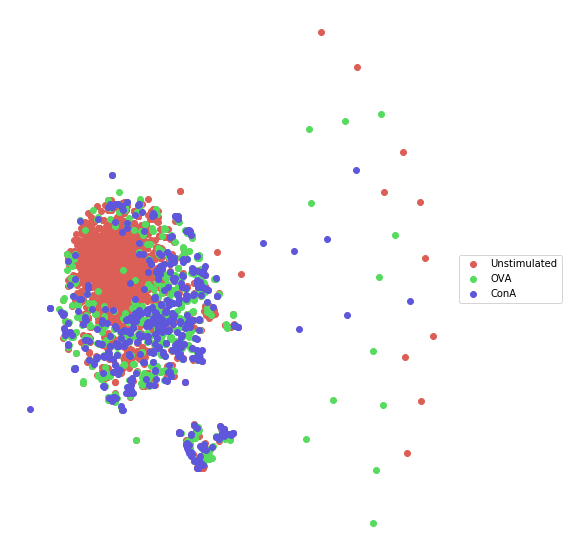

In [0]:
# images masked out, reduced model with PReLU
x_tsne = TSNE(random_state=RS, perplexity=5, learning_rate=200, n_iter=2500).fit_transform(encoded)
plot_tsne(x_tsne, y_train)

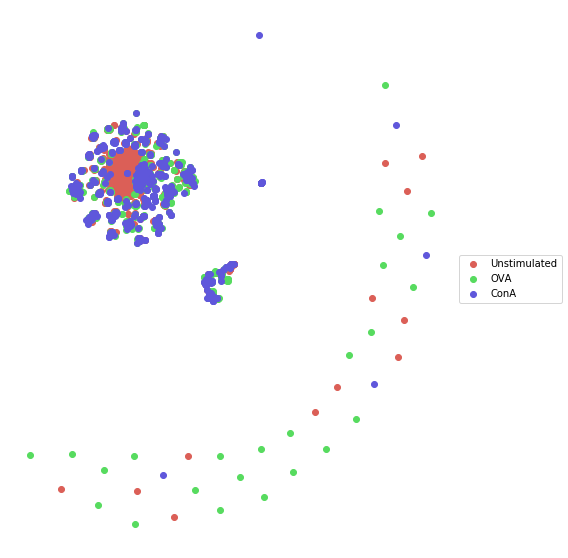

In [0]:
# images masked out, reduced model with LeakyReLU
x_tsne = TSNE(random_state=RS, perplexity=5, learning_rate=200, n_iter=2500).fit_transform(encoded)
plot_tsne(x_tsne, y_train)

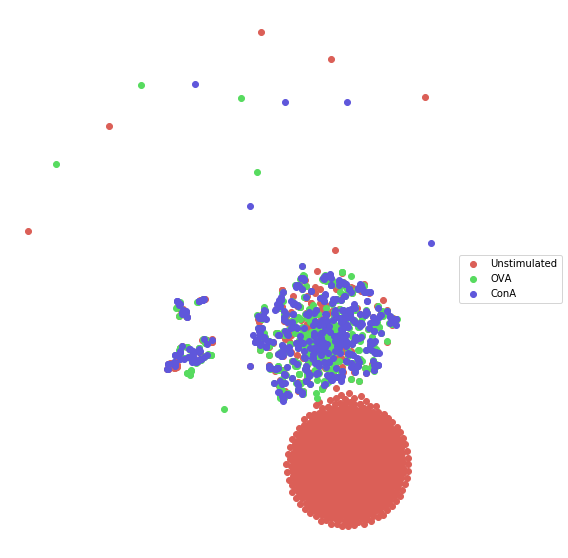

In [0]:
# images masked out, bigger autoencoder, leakyrelu 
x_tsne = TSNE(random_state=RS, perplexity=5, learning_rate=200, n_iter=2500).fit_transform(encoded[:3000])
plot_tsne(x_tsne, y_train[:3000])

## DMSO dataset minmax normalised (!per dataset!), combined

In [0]:
X = npzfile['x']

In [0]:
c = 3

In [0]:
idx = 0
j = 0
x_perdataset = np.ndarray(shape=(len(X)//2, 192, 192, c))
y_perdataset = np.ndarray(shape=(len(X)//2))

mind = np.min(X)
maxd = np.max(X)

while idx < (len(X)):
  if (idx % 100 == 0) and (idx % 200 != 0):
    idx += 100
  else:
    x_perdataset[j, :, :, 0] = low_clip(X[idx])/maxd
    x_perdataset[j, :, :, 1] = low_clip(X[idx+100])/maxd
    y_perdataset[j] = y_dmso[idx]
    idx+=1
    j+=1

In [0]:
x_train, y_train = unishuffle(x_perdataset, y_perdataset)

In [0]:
input_img = Input(shape=(imw, imh, c))

x = Conv2D(32, (3, 3), padding='same')(input_img)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), padding='same')(encoded)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding="same")(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(c, (3, 3), activation='sigmoid', padding='same')(x)

In [0]:
decoder = Model(input_img, decoded)
decoder.compile(optimizer='adam', loss='binary_crossentropy')




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
show_image(x_train[15])









Epoch 1/10
9600/9600 [==============================] - 24s 2ms/step - loss: 0.2359
Epoch 2/10
9600/9600 [==============================] - 22s 2ms/step - loss: 0.1955
Epoch 3/10
9600/9600 [==============================] - 21s 2ms/step - loss: 0.1938
Epoch 4/10
9600/9600 [==============================] - 22s 2ms/step - loss: 0.1934
Epoch 5/10
9600/9600 [==============================] - 22s 2ms/step - loss: 0.1933
Epoch 6/10
9600/9600 [==============================] - 21s 2ms/step - loss: 0.1932
Epoch 7/10
9600/9600 [==============================] - 21s 2ms/step - loss: 0.1931
Epoch 8/10
9600/9600 [==============================] - 21s 2ms/step - loss: 0.1931
Epoch 9/10
9600/9600 [==============================] - 21s 2ms/step - loss: 0.1931
Epoch 10/10
9600/9600 [==============================] - 21s 2ms/step - loss: 0.1930
Weight difference: [ 0.01644382 -0.06216705]


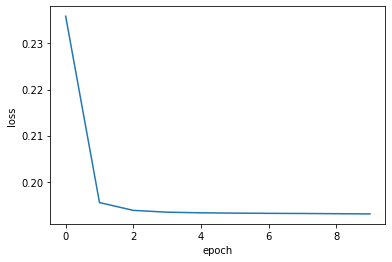

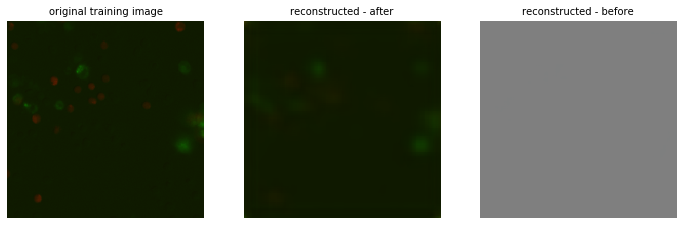

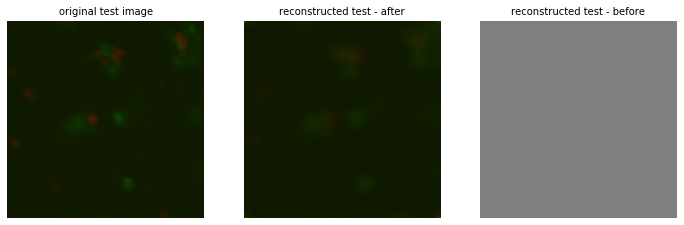

In [0]:
run_evaluation(decoder, x_train[:-200], x_train[-200:], batch_size=64, epochs=10)

In [0]:
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_train)
encoded = np.reshape(encoded_imgs, (len(encoded_imgs), 24*24*8))

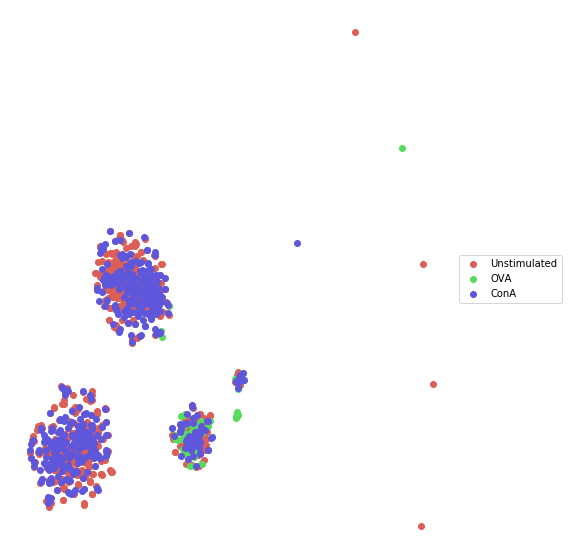

In [0]:
x_tsne = TSNE(random_state=RS, perplexity=5, learning_rate=200, n_iter=2500).fit_transform(encoded[:1000])
plot_tsne(x_tsne, y_train[:1000])

## High dimensional visualisation to GIF

In [0]:
# monkey patch gradient descent 
import sklearn

positions = []

def _gradient_descent(objective, p0, it, n_iter,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7, verbose=0, args=None, kwargs=None):

    if args is None:
        args = []
    if kwargs is None:
        kwargs = {}

    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it

    for i in range(it, n_iter):
        positions.append(p.copy())
        
        check_convergence = (i + 1) % n_iter_check == 0
        # only compute the error when needed
        kwargs['compute_error'] = check_convergence or i == n_iter - 1

        error, grad = objective(p, *args, **kwargs)
        grad_norm = linalg.norm(grad)

        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

        if check_convergence:

            if verbose >= 2:
                print("[t-SNE] Iteration %d: error = %.7f,"
                      " gradient norm = %.7f"
                      " (%s iterations in %0.3fs)"
                      % (i + 1, error, grad_norm, n_iter_check, duration))

            if error < best_error:
                best_error = error
                best_iter = i
            elif i - best_iter > n_iter_without_progress:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: did not make any progress "
                          "during the last %d episodes. Finished."
                          % (i + 1, n_iter_without_progress))
                break
            if grad_norm <= min_grad_norm:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: gradient norm %f. Finished."
                          % (i + 1, grad_norm))
                break

    return p, error, i

sklearn.manifold.t_sne._gradient_descent = _gradient_descent

In [0]:
def scatter_gif(x, colors, labels=["Unstimulated", "OVA", "ConA"]):
    palette = np.array(sns.color_palette("hls", len(labels)))
    colors = np.array(colors)
    
    f = plt.figure(figsize=(8,8))
    ax = plt.subplot()
    
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    return f, sc

In [0]:
from scipy import linalg

from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

In [0]:
def make_gif(out, x, y, labels=["Unstimulated", "OVA", "ConA"]):
    def make_frame_mpl(t):
        i = int(t*40)
        x = X_iter[..., i]
        sc.set_offsets(x)
        return mplfig_to_npimage(f)

    X_proj = TSNE(random_state=RS).fit_transform(x)
    X_iter = np.dstack(position.reshape(-1, 2) for position in positions)
    
    f, sc = scatter_gif(X_iter[..., -1], y, labels=labels)
    
    animation = mpy.VideoClip(make_frame_mpl,
                          duration=X_iter.shape[2]/40.)
    animation.write_gif(out, fps=20)

In [0]:
make_gif('/content/gdrive/My Drive/l4_dataset/cluster_combined_1.gif', encoded, y_combined)
